In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Horizontal velocities

In a flowline example (with perpendicular symmetry), the weight of an ice column is

$$\sigma = \rho g h.$$

With this, the component of weight parallel to the inclined plane of interest with angle $\alpha$ is 

$$\sigma_{xz} = \rho g h \sin \alpha$$

Glen's flow law states that:

$$ \epsilon = A\tau^n$$

where $\epsilon$ is the strain rate, $A$ and $n$ are constants ($n$ often equals 3, unless?) and $\tau$ is the basal shear stress. If the ice is moving over the base with basal velocity $u_s$, the surface velocity $u_s$ can be expressed as

$$ u_s = \frac{2A}{n + 1}\left(\rho g \frac{\partial H}{\partial x}\right)^n H^{n+1} + u_b.$$

These equations are known as the shallow ice approcimation (where we omit friction from the horizontal boundaries). We can try and compute a reasonable velocity profile with these assumptions. All of this information comes from https://people.ee.ethz.ch/~fwalter/download/pdf/pdg_1_3.pdf.




(0.0, 100.0)

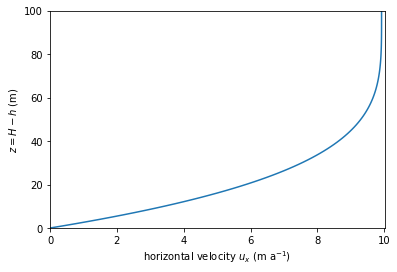

In [3]:
spy = 3600 * 24 * 365  # seconds per year 

# parameters
H     = 100       # Total ice thickness, in meters
A     = 2.4e-24   # Glen's flow law constant, Pa^-3 s^-1
n     = 3         # Glen's flow law constant, unitless
rho   = 1e3       # Ice density, Kg m^-3
g     = 9.81      # Gravitation acceleration, m s^-1
u_b   = 0/spy     # Basal velocity, in m s^-1
alpha = 8         # Surface slope, in degrees
nn    = 100      # Number of nodes

X = 1000          # Length of the domain, in meters
x = np.linspace(0, X, 1000)

dhdx = np.tan(alpha*np.pi/180)
h = np.linspace(0, H, nn)
z = H - h

u_x = u_b + 2 * A / (n + 1) * (rho * g * dhdx) ** n * (H ** (n+1) - h ** (n+1)) * spy

u_x = u_x[::-1]
z = z[::-1]

plt.plot(u_x, z)
plt.xlabel('horizontal velocity $u_x$ (m a$^{-1}$)')
plt.ylabel('$z = H - h$ (m)')
plt.xlim(u_x.min(), u_x.max()*1.01)
plt.ylim(z.min(), z.max())

It would make sense, that in a real scenario, the velocities would change with horizontal distance in the domain (according to the glacier bed for example). This could be local variations in basal velocities $u_b$. Let's define some horizontal variations according to a sinusoid and some noise.

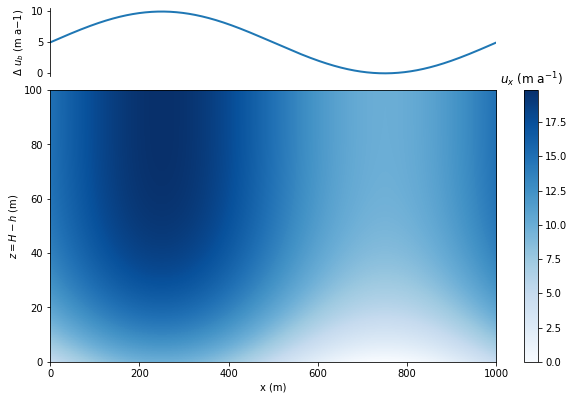

In [4]:
# We need to define parameters for sinusoid
lmbda = 1.0 * X   # Wavelength of the sinusoid
ampli = u_x.max()/2  # A tenth of the ice thickness
sigma = 0/1000 # some noise 

sin = ampli * np.sin(2*np.pi/lmbda * x) + np.random.randn(len(x)) * sigma
sin -= sin.min()


U_x = u_x[:, None] + sin[None, :]

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(U_x, extent=[0, X, 0, H], aspect='auto', cmap='Blues', origin='lower')
cb = plt.colorbar(im)
cb.ax.set_title('$u_x$ (m a$^{-1}$)')
ax.set_xlabel('x (m)')
ax.set_ylabel('$z = H - h$ (m)')


bbox = ax.get_window_extent().transformed(fig.transFigure.inverted())
ax2 = fig.add_axes([bbox.x0, bbox.y1 + (bbox.y1 - bbox.y0) * 0.05, bbox.x1 - bbox.x0, (bbox.y1 - bbox.y0) * 0.25])
ax2.plot(x, sin, lw=2)
ax2.set_xticks([])
ax2.set_ylabel('$\Delta\ u_b$ (m a${-1}$)')
ax2.set_xlim(ax.get_xlim())
#ax2.set_title('Variations in basal velocities (m a$^{-1}$)')
ax2.spines[['top', 'bottom', 'right']].set_visible(False)

### Defining vertical velocities

According to *Fundamentals of Glacier Dynamics* from C.J. Van Der Veen, we can compute the vertical velocities with the relation:

$$ u_z = u_z(0)\left[ 1 - \frac{h}{H}
\left(\frac{n + 2}{n + 1} - \frac{(\frac{h}{H}) ^ {n+1}}{n + 1}\right) \right]$$

with 

$$u_z(0) = - \frac{n+1}{n+2}\frac{\partial u(0)}{\partial x}.$$

Let's design a velocity field made so that our diffractors don't flow out of the ice surface. 

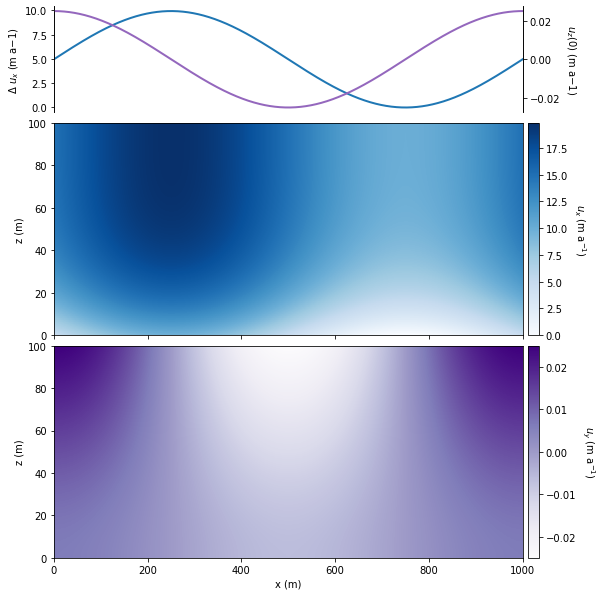

In [5]:
u_z0 = (n+1)/(n+2) * np.gradient(U_x[0], x)

s = np.linspace(1, 0, nn)[:, None]
U_z = u_z0[None, :]*(1 - s * ((n+2)/(n+1) - (s**n+1)/(n+1)))


fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex='col')
fig.subplots_adjust(hspace=0.05)
im = axs[0].imshow(U_x, extent=[0, X, 0, H], aspect='auto', cmap='Blues', origin='lower')
cb = plt.colorbar(im, ax=axs[0], pad=0.01)
cb.ax.set_ylabel('$u_x$ (m a$^{-1}$)', rotation=270, va='bottom')
axs[0].set_ylabel('z (m)')

im = axs[1].imshow(U_z, extent=[0, X, 0, H], aspect='auto', cmap='Purples', origin='lower')
cb = plt.colorbar(im, ax=axs[1], pad=0.01)
cb.ax.set_ylabel('$u_y$ (m a$^{-1}$)', rotation=270, va='bottom')
axs[1].set_ylabel('z (m)')
axs[1].set_xlabel('x (m)')

bbox = axs[0].get_window_extent().transformed(fig.transFigure.inverted())
ax2 = fig.add_axes([bbox.x0, bbox.y1 + (bbox.y1 - bbox.y0) * 0.05, bbox.x1 - bbox.x0, (bbox.y1 - bbox.y0) * 0.5])
ax2.plot(x, sin, lw=2)
ax2.set_xticks([])
ax2.set_ylabel('$\Delta\ u_x$ (m a${-1}$)')
ax2.set_xlim(ax.get_xlim())

ax3 = ax2.twinx()
ax3.plot(x, u_z0, lw=2, c='tab:purple')
ax3.set_ylabel('$u_z(0)$ (m a${-1}$)', rotation=270, va='bottom')

for ax in (ax2, ax3):
    ax.spines[['top', 'bottom']].set_visible(False)

### Propagating diffractors according to this profile
With the velocities defined, we can propagate randomly defined in our domain.

In [29]:
# we need to define the surface velocities as as function of height
from scipy.interpolate import RectBivariateSpline

f_x = RectBivariateSpline(x, z, U_x.T)
f_z = RectBivariateSpline(x, z, 0*U_z.T)

# parameters
npar       = 1e3     # number of particles to propagate
total_time = 10      # time of propagation, in years
dt         = 0.5    # time step, in years

nsteps = int(total_time/dt)

x0 = np.random.uniform(0, X, int(npar))
z0 = np.random.uniform(0, H, int(npar))

x1 = np.zeros((nsteps, int(npar)))
z1 = np.zeros((nsteps, int(npar)))

x1[0] = x0
z1[0] = z0

for i in range(nsteps - 1):
    
    print(f'\riteration {i+1}/{nsteps - 1}', end='')
    
    dx = f_x(x1[i], z1[i], grid=False)*dt
    dz = f_z(x1[i], z1[i], grid=False)*dt
    x1[i + 1] = x1[i] + dx
    z1[i + 1] = z1[i] + dz

# we can plot the particles, it's very laggy when theres a lot of particles to track
plt.scatter(x0, z0, zorder=2, ec='k')
for i, t in enumerate(np.linspace(0, nsteps - 1, 5).astype(int)):
    plt.scatter(x1[t], z1[t], c='k', s=5)

plt.scatter(x1[-1], z1[-1], zorder=1, ec='k')
plt.plot(x1, z1, zorder=0, c='k', lw=0.5)

plt.gca().set_aspect(5)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

print()

iteration 19/19


### Creating a resistivity model

We need to bin the scatterer locations in order to put it into the GPR forward model. This can be done by dividing the domain into small cells and define a mask where we have scatterers located. 

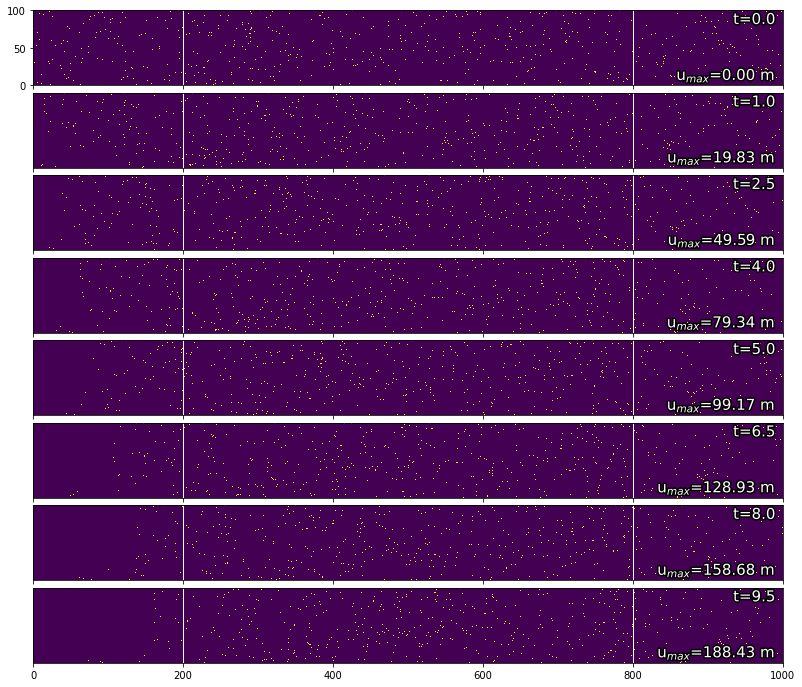

In [30]:
%matplotlib inline
def bin2d(xbin, zbin, xi, zi):
    
    hist, xedges, zedges = np.histogram2d(xi, zi, (xbin, zbin))
    hist[hist > 0] = 1
    return hist, xedges, zedges

norm = np.sqrt(U_x ** 2 + U_z **2)

dx = 1.0
dz = 1.0

xbin = np.arange(0, x.max() + dx, dx)
zbin = np.arange(0, z.max() + dz, dz)

nplots = 8

fig, axs = plt.subplots(nplots, 1, sharex='all', sharey='all', figsize=(nplots*2, nplots*1.5))
fig.subplots_adjust(hspace=0.1)

from matplotlib import patheffects as pe
text_params = dict(fontsize=15, c='w',
                   path_effects=[pe.Stroke(linewidth=3, 
                                           foreground='black'), pe.Normal()])

for i, t in enumerate(np.linspace(0, nsteps - 1, len(axs)).astype(int)):
    hist, xedges, zedges = bin2d(xbin, zbin, x1[t], z1[t])
    axs[i].pcolormesh(xedges, zedges, hist.T)
    axs[i].text(0.99, 0.98, f't={t*dt:.1f}', 
                transform=axs[i].transAxes, 
                ha='right', va='top', 
                 **text_params)   
    
    axs[i].text(0.99, 0.01, f'u$_{{max}}$={norm.max()*dt*t:.2f} m',
                ha='right', va='bottom', 
                transform=axs[i].transAxes, 
                **text_params)
    axs[i].set_aspect(1)
    axs[i].vlines((200, 800), 0, H, colors='w', linewidths=1)
    
    if i > 0:
        axs[i].tick_params(axis='y', which='both', labelleft=False, length=0)
    

In [41]:
# we can do it in a vectorized way, computing the histograms for every time step
histograms = np.zeros((nsteps, len(xbin), len(zbin)))
outx = np.digitize(x1, xbin) - 1
outz = np.digitize(z1, zbin) - 1

for i in range(nsteps):
    histograms[i, outx[i], outz[i]] += 1
    
# we need to flip it along the y axis for some reason
histograms = histograms[:, :, ::-1]

# we mask every cell bigger than one as a scatterer
histograms[histograms > 0] = 1

# we mask the bed with 2
histograms[:, :, -5:] = 2

plt.imshow(histograms[-1].T)

In [32]:
print(np.abs(xedges - 200).argmin())
print(np.abs(xedges - 800).argmin())
print(xedges.shape)
print(zedges.shape)
print(histograms.shape)

200
800
(1001,)
(101,)
(20, 1001, 101)


In [45]:
# we can also create an animation where the cells are moving with time
%matplotlib notebook
      
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()
im = ax.imshow(histograms[0].T, aspect='auto', extent=[0, xbin.max(), 0, zbin.max()])
text = ax.set_title(f't=0.0')

def update(i):
    im.set_data(histograms[i].T)
    text.set_text(f't={i*dt:.1f}')
    return im, text
    
anim = FuncAnimation(fig, update, frames=np.arange(0, nsteps, 1), interval=100)#, blit=True)
plt.show()

In [36]:
%matplotlib
# zooming in on the survey
fig, ax = plt.subplots()
im = ax.imshow(histograms[0, ::-1].T, aspect='auto', extent=[0, xbin.max(), 0, zbin.max()])
ax.set_xlim(200, 800)
text = ax.set_title(f't=0.0')
ax.set_aspect(1)

def update(i):
    im.set_data(histograms[i].T)
    text.set_text(f't={i*dt:.1f}')
    return im, text
    
anim = FuncAnimation(fig, update, frames=np.arange(0, nsteps, 1), interval=100)#, blit=True)
plt.show()

Using matplotlib backend: Qt5Agg


### Defining the materials

We need to define three values for the tree different materials (ice, scatterers and the bedrock):

- The relative dielectric permittivity $\epsilon$
- The relative electrical conductivity $\sigma$
- The relative magnetic permeability $\mu$

For the ice, $\epsilon_{ice}=3.5$ and $\sigma_{ice}= 0$. For the bedrock, $\epsilon_{bed}=6$ and $\sigma_{bed}=1$. Finally, for the scatterers, $\epsilon_{scat}=???$ and $\sigma_{scat}=???$. The relative magnetic permeability will be set to one for every material.

In [44]:
# dielectric permittivity of the materials
eps_ice = 3.5
eps_bed = 6
eps_scat = 20

# relative electrical conductivity of the materials
sigma_ice = 0.01
sigma_bed = 1
sigma_scat = 10

mu_all = 1

# base values
ep0 = 8.8541878176e-12
mu0 = 1.2566370614e-6
sig0 = 1e-3

eps = np.zeros_like(histograms).astype(np.float32)
eps[histograms == 0] = eps_ice
eps[histograms == 1] = eps_scat
eps[histograms == 2] = eps_bed
eps = eps * ep0
print(eps.shape)

sigma = np.zeros_like(histograms).astype(np.float32)
sigma[histograms == 0] = sigma_ice
sigma[histograms == 1] = sigma_scat
sigma[histograms == 2] = sigma_bed
sigma = sigma * sig0

mu = np.ones_like(histograms).astype(np.float32) * mu0

eps.dump('data/eps.npy')
sigma.dump('data/sigma.npy')
mu.dump('data/mu.npy')

(20, 1001, 101)
